In [1]:
import pandas as pd
from datetime import datetime
from itertools import dropwhile, takewhile
from instagram_web_api import Client, ClientError, ClientLoginError, ClientCookieExpiredError
import string
import random
import networkx as nx
import datetime
import os
import json
import codecs
import re
import matplotlib.pyplot as plt
import pickle
import numpy as np
import graph_tool.all as gt
import seaborn as sns
import matplotlib.cm as cm
from wordcloud import WordCloud
from functools import reduce

%matplotlib inline
sns.set_context('talk')


In [2]:
remove_tags = ['flashtattoo', 'flashtatt', 'flash', 'flashdesign', 'tat', 'tatted', 'tattoo', 'inked', 'tattooartist', 'nyctattoo',
              'tattooflash', 'tattooer', 'tattooshop','ink','tattooideas','tattooart', 
               'tattooed', 'sftattoo', 'sftattooartist', 'nyctattooartist', 'tattoooftheday', 'tattooink',
              'tattoodesign', 'tattooist', 'tattooing', 'tattoink', 'tatt', 'tattoostyle', 'inkedmag',
              'tattooink','tattoolife']
remove_tags.extend([x + 's' for x in remove_tags])


In [3]:
# clean hashtags
def clean(x, rm_tags, city):
    x = x[x.find('#'):]
    curr_tags = x.split('#')
    # only get first word after hastag
    curr_tags = [x.split(' ')[0] for x in curr_tags]
    # remove punc
    curr_tags = [re.sub(r'[^\w\s]', '', x) for x in curr_tags]
    curr_tags = [x.strip(' ') for x in curr_tags]
    curr_tags = [x.replace('\n','').lower() for x in curr_tags]
    # emojis
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    curr_tags = [emoji_pattern.sub(r'', x) for x in curr_tags]

    # remove common tags    
    curr_tags = [x for x in curr_tags if x not in rm_tags]
    # remove commen prefixes and suffixes
    curr_tags = [x.replace('tattoos','') for x in curr_tags]
    curr_tags = [x.replace('tattoo','') for x in curr_tags]
    curr_tags = [x.replace('artist','') for x in curr_tags]
    curr_tags = [x.replace('art','') for x in curr_tags]
    curr_tags = [x.replace('flash','') for x in curr_tags]
    curr_tags = [x.replace('ofinstagram','') for x in curr_tags]
    curr_tags = [x.replace('insta','') for x in curr_tags]
    for c in city:
        curr_tags = [x.replace(c,'') for x in curr_tags]
    # remove single letters
    curr_tags = ["" if len(x) == 1 else x for x in curr_tags ]
    
    while("" in curr_tags) :
        curr_tags.remove("")
    
    return list(set(curr_tags))

### ny

In [4]:
f = open('./data/nyc', 'rb')
ny = pickle.load(f)

In [5]:
ny_tags = [comment['node']['edge_media_to_caption']['edges'][0]['node']['text'] 
        for comment in ny
       if len(comment['node']['edge_media_to_caption']['edges']) > 0]

In [6]:
clean_ny = [clean(x, remove_tags, ['nyc','newyork','ny']) for x in ny_tags]
clean_ny

[['acst',
  'world',
  'boxer',
  'jprodrigues',
  'lover',
  'hive',
  'westvillage',
  'do',
  'love',
  'lifestyle',
  'boxers',
  'acquasanta',
  'ociety',
  'acstfc___',
  'community',
  'magazine'],
 ['nature',
  'moon',
  'small',
  'floral',
  'illustrative',
  'dainty',
  'thinline',
  'blxckink'],
 ['cherryblossom', 'almondblossom', 'brooklyn', 'cherryblossoms', 'fineline'],
 ['handlettered',
  'enby',
  'brooklyn',
  'queerer',
  'letters',
  'drawnon',
  'qttr',
  'name',
  'freestyle',
  'blackline',
  'grandmaname',
  'blackwork',
  'trad',
  'grandma',
  'blackink',
  'manhattan',
  'traditional',
  'queer'],
 ['city',
  'hand',
  'blackandgrey',
  'magiccobraociety',
  'parkslope',
  'magiccobra',
  'brooklyn',
  'work',
  'explorerpage',
  'msfourtune',
  'rose',
  'leeve',
  'bymaggie',
  'bk',
  'magiccobrasouth'],
 ['blackwork', 'female'],
 ['city',
  'blackandgrey',
  'magiccobraociety',
  'parkslope',
  'magiccobra',
  'brooklyn',
  'geisha',
  'work',
  'explorer

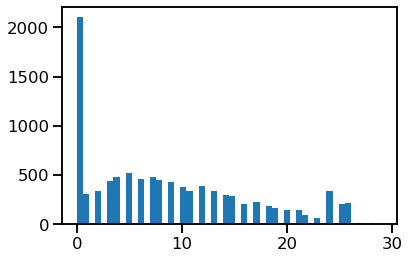

In [7]:
# you're only allowed 30 hashtags on instagram
h = [len(x) for x in clean_ny]
plt.hist(h, bins=50)
plt.show()

In [8]:
# I'm going to remove the second distribution
cohort_ny = [clean_ny[i] for i,x in enumerate(h) if x < 24]

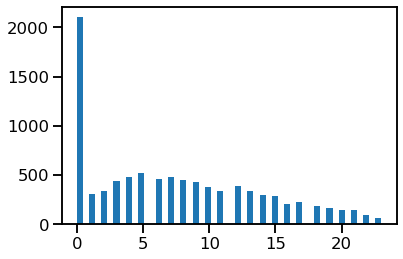

In [9]:
# you're only allowed 30 hashtags on instagram
h = [len(x) for x in cohort_ny]
plt.hist(h, bins=50)
plt.show()

In [10]:
ny_graph = dict()
ny_attrs = dict()
for k in range(len(cohort_ny)):
    ny_graph[k] = [x for x in range(len(cohort_ny))
                    if (x != k) & any(set(cohort_ny[k]).intersection(cohort_ny[x]))]
    for edge in ny_graph[k]:
        if not (edge,k) in ny_attrs:
            # weight: the porportion of tags shared by the node with the most tags (to downweight nodes with lots of #)
            # n: numnber of shared tags
            # tags: shared tags
            ny_attrs[(k,edge)] = {'weight':len( list( set(cohort_ny[k]).intersection(cohort_ny[edge]) ) ) / 
                               np.min([ len(cohort_ny[k]), len(cohort_ny[edge]) ]),
                              'n':len( list( set(cohort_ny[k]).intersection(cohort_ny[edge]) ) ),
                              'tags':set(cohort_ny[k]).intersection(cohort_ny[edge])}
g = nx.Graph(ny_graph)
nx.set_edge_attributes(g,ny_attrs)


In [11]:
# what are the most popular tags?
ny_data = {}
for key in ny_attrs.keys():
    tags = ny_attrs[key]['tags']
    for t in tags:
        if t in ny_data.keys():
            ny_data[t] = ny_data[t] + 1
        else:
            ny_data[t] = 1
            

In [12]:
ny_data = dict(sorted(ny_data.items(), key=lambda item: item[1], reverse=True))
ny_data

{'brooklyn': 2871606,
 'fineline': 1000405,
 'blackwork': 609960,
 'blackandgrey': 334153,
 'linework': 243253,
 'color': 184528,
 'traditional': 148240,
 'tttism': 113526,
 'flower': 104196,
 'manhattan': 99681,
 'qttr': 97020,
 'small': 79401,
 'handpoke': 79401,
 'illustration': 76636,
 'black': 75855,
 'queer': 74305,
 'do': 72010,
 'female': 71631,
 'cute': 64980,
 'floral': 61075,
 'la': 60031,
 'singleneedle': 52975,
 'anime': 52326,
 'handpoked': 50721,
 'arm': 48516,
 'ink': 44850,
 'hop': 40186,
 'dotwork': 39903,
 'realism': 37950,
 'blackworkers': 37675,
 'contemporary': 34453,
 'stickandpoke': 33930,
 'losangeles': 33930,
 'drawing': 31375,
 'london': 30135,
 'bushwick': 29403,
 'ignorantstyle': 28920,
 'city': 28441,
 'illustrative': 27495,
 'nj': 27495,
 'girl': 27261,
 'ti': 25200,
 'minimal': 24090,
 'inspiration': 23871,
 'abstract': 23653,
 'dark': 23653,
 'inkedup': 23653,
 'botanical': 23653,
 'machine': 23653,
 'williamsburg': 23436,
 'realistic': 23436,
 'love': 

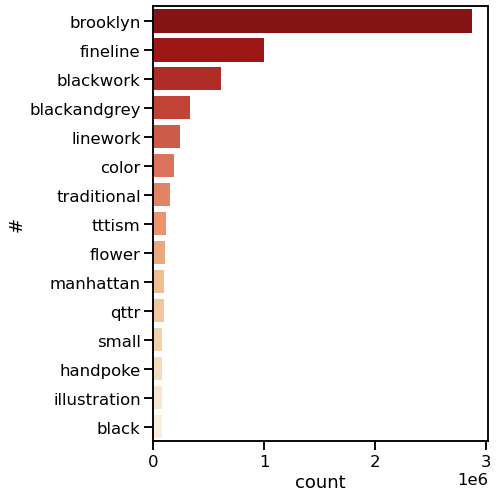

In [13]:
plt.figure(figsize=(6,8))
ny_df = pd.DataFrame.from_dict(orient='index', columns=['count'], data=ny_data).reset_index()
ny_df.sort_values(by='count', ascending=False, inplace=True)
sns.barplot(x="count", y="index", data=ny_df[0:15], palette='OrRd_r')
plt.ylabel('#')
plt.savefig('./data/ny_toptags.png')

In [14]:
# remove disconnected nodes
g.remove_nodes_from(list(nx.isolates(g)))
nx.info(g)


/var/folders/h0/l69z4pld3jjbbqfdh7c7l4rr02cs7w/T/ipykernel_27341/3916248000.py:3: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  nx.info(g)


'Graph with 7120 nodes and 6437697 edges'

(array([455., 228., 199., 181., 348., 158., 195., 170., 204., 202., 195.,
        156., 183., 149., 109., 161., 148., 147., 119., 148., 102., 127.,
        146.,  95.,  82., 236., 276., 206., 134., 137., 105., 137., 135.,
        108., 158., 165., 144., 116., 116., 130., 196.,  65.,  36.,  34.,
         33.,  25.,   7.,   1.,  11.,   2.]),
 array([1.00000e+00, 9.63200e+01, 1.91640e+02, 2.86960e+02, 3.82280e+02,
        4.77600e+02, 5.72920e+02, 6.68240e+02, 7.63560e+02, 8.58880e+02,
        9.54200e+02, 1.04952e+03, 1.14484e+03, 1.24016e+03, 1.33548e+03,
        1.43080e+03, 1.52612e+03, 1.62144e+03, 1.71676e+03, 1.81208e+03,
        1.90740e+03, 2.00272e+03, 2.09804e+03, 2.19336e+03, 2.28868e+03,
        2.38400e+03, 2.47932e+03, 2.57464e+03, 2.66996e+03, 2.76528e+03,
        2.86060e+03, 2.95592e+03, 3.05124e+03, 3.14656e+03, 3.24188e+03,
        3.33720e+03, 3.43252e+03, 3.52784e+03, 3.62316e+03, 3.71848e+03,
        3.81380e+03, 3.90912e+03, 4.00444e+03, 4.09976e+03, 4.19508e+03,
 

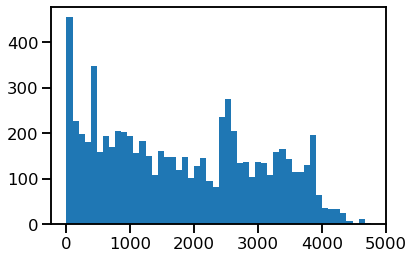

In [15]:
degree_sequence = sorted([d for n, d in g.degree()], reverse=True)  # degree sequence

plt.hist(degree_sequence, bins=50)


(array([2.931e+03, 1.732e+03, 1.377e+03, 8.900e+02, 8.300e+01, 6.400e+01,
        1.000e+01, 1.000e+00, 3.000e+00, 2.900e+01]),
 array([3.33333333e-01, 2.39900000e+02, 4.79466667e+02, 7.19033333e+02,
        9.58600000e+02, 1.19816667e+03, 1.43773333e+03, 1.67730000e+03,
        1.91686667e+03, 2.15643333e+03, 2.39600000e+03]),
 <BarContainer object of 10 artists>)

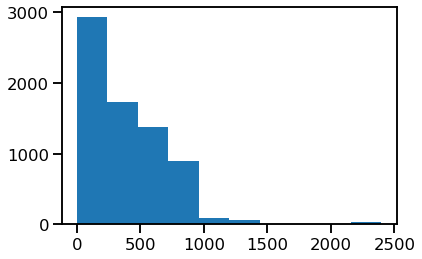

In [16]:
strength_sequence = sorted([d for n, d in g.degree(weight='weight')], reverse=True)  # degree sequence

plt.hist(strength_sequence)


(array([1901., 1179., 1007., 1162.,  766.,  442.,  278.,  301.,   76.,
           8.]),
 array([1.0000e+00, 8.7460e+02, 1.7482e+03, 2.6218e+03, 3.4954e+03,
        4.3690e+03, 5.2426e+03, 6.1162e+03, 6.9898e+03, 7.8634e+03,
        8.7370e+03]),
 <BarContainer object of 10 artists>)

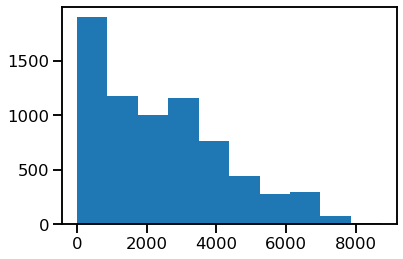

In [17]:
n_sequence = sorted([d for n, d in g.degree(weight='n')], reverse=True)  # degree sequence

plt.hist(n_sequence)

In [18]:
edges = [(i, j) for i in ny_graph for j in ny_graph[i]]
G = gt.Graph(directed = False)
G.add_edge_list(edges)
del_list = G.get_out_degrees(G.get_vertices())
print(len(del_list))
print(sum(del_list == 0))
for v in reversed(sorted(np.where(del_list == 0))):
    G.remove_vertex(v)
U = gt.extract_largest_component(G)

9283
2163


In [19]:
clusters = gt.minimize_blockmodel_dl(U)

In [ ]:
layout = 'fruchterman_reingold'
plt.figure(figsize=(12,12))
clusters.draw(layout=layout, output=f'./data/nyc_sbm_{layout}.png')

/Users/stisoj/opt/anaconda3/envs/tattoo/lib/python3.10/site-packages/graph_tool/draw/cairo_draw.py:634: UserWarning: Unknown parameter: layout
  warnings.warn("Unknown parameter: " + k, UserWarning)


In [ ]:
# second largest component
l = gt.label_largest_component(G)
m = [1 if x == 0 else 0 for x in l]
u = gt.GraphView(G, vfilt=m)
print(u.num_vertices())

In [ ]:
clusters = gt.minimize_blockmodel_dl(u)

In [ ]:
plt.figure(figsize=(12,12))
clusters.draw(output='./data/nyc_sbm2.png')

#### bipartite graph

In [ ]:
from collections import defaultdict

## create a graph
ny_g = gt.Graph(directed=False)
## define node properties
## name: docs - title, words - 'word'
## kind: docs - 0, words - 1
name = ny_g.vp["name"] = ny_g.new_vp("string")
kind = ny_g.vp["kind"] = ny_g.new_vp("int")

posts_add = defaultdict(lambda: ny_g.add_vertex())
tags_add = defaultdict(lambda: ny_g.add_vertex())


## add all posts and tags as nodes
## add all tokens as links
for i_d in range(len(cohort_ny)):
    p=posts_add[str(i_d)]
    name[p] = str(i_d)
    kind[p] = 0
    curr_tags = cohort_ny[i_d]
    for t in curr_tags:
        if not any([name[vertex] == t for vertex in ny_g.iter_vertices()]):
            ta=tags_add[t]
            name[ta] = t
            kind[ta] = 1
        ny_g.add_edge(p,ta)


In [ ]:
del_list = ny_g.get_out_degrees(ny_g.get_vertices())
print(len(del_list))
print(sum(del_list == 0))
for v in reversed(sorted(np.where(del_list == 0))):
    ny_g.remove_vertex(v)

ny_g

In [ ]:
ny_state = gt.minimize_nested_blockmodel_dl(ny_g)

In [ ]:
L = 0
for s in state.levels:
    L += 1
    if s.get_nonempty_B() == 2:
        break
ny_state = ny_state.copy(bs=state.get_bs()[:L] + [np.zeros(1)])
print(state.entropy())

In [ ]:
ny_state.draw(layout='bipartite', output='./data/bp_ny_nsbm.png')

In [ ]:
ny_state.print_summary()

In [ ]:
levels = ny_state.get_levels()
for s in levels:
    print(s)
    if s.get_N() == 1:
        break

In [ ]:
levels = ny_state.get_levels()
cnt = 0
lvl_name = []
for s in levels:
    b = s.get_blocks()
    print(f'Block: {cnt}')
    lvl_name.append(f'lvl_{cnt}')
    print(pd.Series.value_counts([x for x in b]).head())
    print(f'\n Number of groups: {len(pd.Series.value_counts([x for x in b]))}')
    print(f'\n Number of 1 node groups: {sum(pd.Series.value_counts([x for x in b]) == 1)}')
    print('\n')
    
    cnt = cnt + 1
    if s.get_N() == 1:
        break

In [ ]:
levels = ny_state.get_levels()
for s in levels:    
    b = gt.contiguous_map(s.get_blocks())
    st = s.copy(b=b)

    e = st.get_matrix()

    B = st.get_nonempty_B()
    plt.matshow(e.todense()[:B, :B])
    
    if s.get_N() == 1:
        break

In [ ]:
lvl_name.extend(['kind', 'name'])
ny_sbm_df = pd.DataFrame(columns=lvl_name)
levels = ny_state.get_levels()

for n in ny_g.get_vertices():
    ny_sbm_df.loc[n,'kind'] = ny_g.vp["kind"][n]
    ny_sbm_df.loc[n,'name'] = ny_g.vp["name"][n]
    r = n
    for i,s in enumerate(levels):
        r = levels[i].get_blocks()[r] 
        ny_sbm_df.loc[n, f'lvl_{i}'] = r
        
        if s.get_N() == 1:
            break

In [ ]:
ny_sbm_df.head()

In [ ]:
ny_sbm = pd.DataFrame(columns=['lvl','block','tag','n_posts_block','n_posts_tag', 'rank', 'block_rank'])
for i,s in enumerate(levels):
    
    curr_tags = ny_sbm_df.loc[ny_sbm_df.kind==1, [f'lvl_{i}', 'name']]
    curr_posts = ny_sbm_df.loc[ny_sbm_df.kind==0, [f'lvl_{i}', 'name']]
    # loop through tags
    n_posts_tag = []
    for index,row in curr_tags.iterrows():
        block = row[f'lvl_{i}']
        # get all the connected posts
        neighbors = ny_g.get_out_neighbors(index)
        # get overlap with each current
        neighbor_blocks = curr_posts.loc[neighbors, f'lvl_{i}'].values
        n_posts_tag.append(np.sum(neighbor_blocks == block))
        n_posts_block = [x[0] for x in curr_tags.groupby(f'lvl_{i}').transform('count').values]
        rank_tag = [x[0] for x in curr_tags.groupby(f'lvl_{i}').transform('count').apply(np.argsort).values]
        
    curr_sbm = pd.DataFrame(data={'lvl':[i]*len(curr_tags[f'lvl_{i}'].values),
                                  'block':curr_tags[f'lvl_{i}'].values,
                                  'tag':curr_tags['name'].values,
                                  'n_posts_block':n_posts_block,
                                  'n_posts_tag':n_posts_tag,
                                  'rank':rank_tag,
                                  'block_rank': pd.Series(n_posts_block).rank(method="dense")[::-1]
                                 })
    ny_sbm = pd.concat([curr_sbm, ny_sbm])
    
    if s.get_N() == 1:
            break
ny_sbm.tail()

In [ ]:
ny_sbm.info()

In [ ]:
lv = 3
def factors(n):    
    return set(reduce(list.__add__, 
                ([i, n//i] for i in range(1, int(n**0.5) + 1) if n % i == 0)))


for block in sf_sbm[sf_sbm['lvl'] == lv].block.unique(): 
    plt_data = ny_sbm[(ny_sbm['lvl'] == lv) & (ny_sbm['block'] == block)]
    
    # normalize block sizes
    plt_data = plt_data.assign(
        block_size_norm =
        sf_sbm.loc[(ny_sbm['lvl'] == lv),'n_posts_block']/ny_sbm.loc[(ny_sbm['lvl'] == lv),'n_posts_block'].max()
    )
    
    # get mask dimensions
    block_size = plt_data['block_size_norm'].values[0]
    # work with the default image size
    block_size = block_size*300
    #block_size = np.round(plt_data['n_posts_block'].values[0]/10)*10
    print(block_size)
    
    x, y = np.ogrid[:np.floor(block_size), :np.ceil(block_size)]
    mask = x + y
    mask = 255 * mask.astype(int)
    
    # make frequency dictionary
    freqs = plt_data[['tag','rank']].set_index('tag').to_dict()['rank']
    wc = WordCloud(background_color="white", max_words=1000, mask=mask, colormap='OrRd')
    # generate word cloud
    wc.generate_from_frequencies(freqs)
    #plot
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()


### sf

In [ ]:
f = open('./data/sf', 'rb')
sf = pickle.load(f)

In [ ]:
sf_tags = [comment['node']['edge_media_to_caption']['edges'][0]['node']['text'] 
        for comment in sf
       if len(comment['node']['edge_media_to_caption']['edges']) > 0]

In [ ]:
clean_sf = [clean(x, remove_tags,['sf', 'sanfrancisco', 'bayarea', 'california']) for x in sf_tags]
clean_sf

In [ ]:
# you're only allowed 30 hashtags on instagram
h = [len(x) for x in clean_sf]
plt.hist(h, bins=50)
plt.show()

In [ ]:
# I'm going to remove the second distribution
cohort_sf = [clean_sf[i] for i,x in enumerate(h) if x < 24]

# you're only allowed 30 hashtags on instagram
h = [len(x) for x in cohort_sf]
plt.hist(h, bins=50)
plt.show()

In [ ]:
sf_graph = dict()
sf_attrs = dict()
for k in range(len(cohort_sf)):
    sf_graph[k] = [x for x in range(len(cohort_sf))
                    if (x != k) & any(set(cohort_sf[k]).intersection(cohort_sf[x]))]
    for edge in sf_graph[k]:
        if not (edge,k) in sf_attrs:
            # weight: the porportion of tags shared by the node with the most tags (to downweight nodes with lots of #)
            # n: numnber of shared tags
            # tags: shared tags
            sf_attrs[(k,edge)] = {'weight':len( list( set(cohort_sf[k]).intersection(cohort_sf[edge]) ) ) / 
                               np.min([ len(cohort_sf[k]), len(cohort_sf[edge]) ]),
                              'n':len( list( set(cohort_sf[k]).intersection(cohort_sf[edge]) ) ),
                              'tags':set(cohort_sf[k]).intersection(cohort_sf[edge])}
g = nx.Graph(sf_graph)
nx.set_edge_attributes(g,sf_attrs)

# what are the most popular tags?
sf_data = {}
for key in sf_attrs.keys():
    tags = sf_attrs[key]['tags']
    for t in tags:
        if t in sf_data.keys():
            sf_data[t] = sf_data[t] + 1
        else:
            sf_data[t] = 1
            

sf_data = dict(sorted(sf_data.items(), key=lambda item: item[1], reverse=True))
sf_data

In [ ]:
plt.figure(figsize=(6,8))
sf_df = pd.DataFrame.from_dict(orient='index', columns=['count'], data=sf_data).reset_index()
sf_df.sort_values(by='count', ascending=False, inplace=True)
sns.barplot(x="count", y="index", data=sf_df[0:15], palette='GnBu_r')
plt.ylabel('#')
plt.savefig('./data/sf_toptags.png')

In [ ]:
# remove disconnected nodes
g.remove_nodes_from(list(nx.isolates(g)))
nx.info(g)

In [ ]:
# remove disconnected nodes
g.remove_nodes_from(list(nx.isolates(g)))
nx.info(g)

In [ ]:
degree_sequence = sorted([d for n, d in g.degree()], reverse=True)  # degree sequence

plt.hist(degree_sequence, bins=50)

In [ ]:
strength_sequence = sorted([d for n, d in g.degree(weight='weight')], reverse=True)  # degree sequence

plt.hist(strength_sequence)

In [ ]:
n_sequence = sorted([d for n, d in g.degree(weight='n')], reverse=True)  # degree sequence

plt.hist(n_sequence)

In [ ]:
edges = [(i, j) for i in sf_graph for j in sf_graph[i]]
G = gt.Graph(directed = False)
G.add_edge_list(edges)
del_list = G.get_out_degrees(G.get_vertices())
print(len(del_list))
print(sum(del_list == 0))
for v in reversed(sorted(np.where(del_list == 0))):
    G.remove_vertex(v)
U = gt.extract_largest_component(G)

In [ ]:
clusters = gt.minimize_blockmodel_dl(U)

In [ ]:
layout = 'radial_tree_layout'
plt.figure(figsize=(12,12))
clusters.draw(layout=layout, output=f'./data/sf_sbm_{layout}.png')

In [ ]:
# second largest component
l = gt.label_largest_component(G)
m = [1 if x == 0 else 0 for x in l]
u = gt.GraphView(G, vfilt=m)
print(u.num_vertices())

clusters = gt.minimize_blockmodel_dl(u)

plt.figure(figsize=(12,12))
clusters.draw(output='./data/sf_sbm2.png')

#### bipartite graph

In [ ]:
from collections import defaultdict

## create a graph
sf_g = gt.Graph(directed=False)
## define node properties
## name: docs - title, words - 'word'
## kind: docs - 0, words - 1
name = sf_g.vp["name"] = sf_g.new_vp("string")
kind = sf_g.vp["kind"] = sf_g.new_vp("int")

posts_add = defaultdict(lambda: sf_g.add_vertex())
tags_add = defaultdict(lambda: sf_g.add_vertex())


## add all posts and tags as nodes
## add all tokens as links
for i_d in range(len(cohort_sf)):
    p=posts_add[str(i_d)]
    name[p] = str(i_d)
    kind[p] = 0
    curr_tags = cohort_sf[i_d]
    for t in curr_tags:
        if not any([name[vertex] == t for vertex in sf_g.iter_vertices()]):
            ta=tags_add[t]
            name[ta] = t
            kind[ta] = 1
        sf_g.add_edge(p,ta)


In [ ]:
del_list = sf_g.get_out_degrees(sf_g.get_vertices())
print(len(del_list))
print(sum(del_list == 0))
for v in reversed(sorted(np.where(del_list == 0))):
    sf_g.remove_vertex(v)
sf_g

In [ ]:
state = gt.minimize_nested_blockmodel_dl(sf_g)

In [ ]:
L = 0
for s in state.levels:
    L += 1
    if s.get_nonempty_B() == 2:
        break
state = state.copy(bs=state.get_bs()[:L] + [np.zeros(1)])
print(state.entropy())

In [ ]:
state.draw(layout='bipartite', output='./data/bp_sf_nsbm.png')

In [ ]:
state.print_summary()

In [ ]:
levels = state.get_levels()
for s in levels:
    print(s)
    if s.get_N() == 1:
        break

In [ ]:
levels = state.get_levels()
cnt = 0
lvl_name = []
for s in levels:
    b = s.get_blocks()
    print(f'Block: {cnt}')
    lvl_name.append(f'lvl_{cnt}')
    print(pd.Series.value_counts([x for x in b]).head())
    print(f'\n Number of groups: {len(pd.Series.value_counts([x for x in b]))}')
    print(f'\n Number of 1 node groups: {sum(pd.Series.value_counts([x for x in b]) == 1)}')
    print('\n')
    
    cnt = cnt + 1
    if s.get_N() == 1:
        break

In [ ]:
levels = state.get_levels()
for s in levels:    
    b = gt.contiguous_map(s.get_blocks())
    st = s.copy(b=b)

    e = st.get_matrix()

    B = st.get_nonempty_B()
    plt.matshow(e.todense()[:B, :B])
    
    if s.get_N() == 1:
        break

In [ ]:
lvl_name.extend(['kind', 'name'])
sf_sbm_df = pd.DataFrame(columns=lvl_name)
levels = state.get_levels()

for n in sf_g.get_vertices():
    sf_sbm_df.loc[n,'kind'] = sf_g.vp["kind"][n]
    sf_sbm_df.loc[n,'name'] = sf_g.vp["name"][n]
    r = n
    for i,s in enumerate(levels):
        r = levels[i].get_blocks()[r] 
        sf_sbm_df.loc[n, f'lvl_{i}'] = r
        
        if s.get_N() == 1:
            break

In [ ]:
sf_sbm_df.tail()

In [ ]:
sf_sbm = pd.DataFrame(columns=['lvl','block','tag','n_posts_block','n_posts_tag', 'rank', 'block_rank'])
for i,s in enumerate(levels):
    
    curr_tags = sf_sbm_df.loc[sf_sbm_df.kind==1, [f'lvl_{i}', 'name']]
    curr_posts = sf_sbm_df.loc[sf_sbm_df.kind==0, [f'lvl_{i}', 'name']]
    # loop through tags
    n_posts_tag = []
    for index,row in curr_tags.iterrows():
        block = row[f'lvl_{i}']
        # get all the connected posts
        neighbors = sf_g.get_out_neighbors(index)
        # get overlap with each current
        neighbor_blocks = curr_posts.loc[neighbors, f'lvl_{i}'].values
        n_posts_tag.append(np.sum(neighbor_blocks == block))
        n_posts_block = [x[0] for x in curr_tags.groupby(f'lvl_{i}').transform('count').values]
        rank_tag = [x[0] for x in curr_tags.groupby(f'lvl_{i}').transform('count').apply(np.argsort).values]
        
    curr_sbm = pd.DataFrame(data={'lvl':[i]*len(curr_tags[f'lvl_{i}'].values),
                                  'block':curr_tags[f'lvl_{i}'].values,
                                  'tag':curr_tags['name'].values,
                                  'n_posts_block':n_posts_block,
                                  'n_posts_tag':n_posts_tag,
                                  'rank':rank_tag,
                                  'block_rank': pd.Series(n_posts_block).rank(method="dense")[::-1]
                                 })
    sf_sbm = pd.concat([curr_sbm, sf_sbm])
    
    if s.get_N() == 1:
            break
sf_sbm.tail()

In [ ]:
sf_sbm.info()

In [ ]:
lv = 3
def factors(n):    
    return set(reduce(list.__add__, 
                ([i, n//i] for i in range(1, int(n**0.5) + 1) if n % i == 0)))


for block in sf_sbm[sf_sbm['lvl'] == lv].block.unique(): 
    plt_data = sf_sbm[(sf_sbm['lvl'] == lv) & (sf_sbm['block'] == block)]
    
    # normalize block sizes
    plt_data = plt_data.assign(
        block_size_norm =
        sf_sbm.loc[(sf_sbm['lvl'] == lv),'n_posts_block']/sf_sbm.loc[(sf_sbm['lvl'] == lv),'n_posts_block'].max()
    )
    
    # get mask dimensions
    block_size = plt_data['block_size_norm'].values[0]
    # work with the default image size
    block_size = block_size*300
    #block_size = np.round(plt_data['n_posts_block'].values[0]/10)*10
    print(block_size)
    
    x, y = np.ogrid[:np.floor(block_size), :np.ceil(block_size)]
    mask = x + y
    mask = 255 * mask.astype(int)
    
    # make frequency dictionary
    freqs = plt_data[['tag','rank']].set_index('tag').to_dict()['rank']
    wc = WordCloud(background_color="white", max_words=1000, mask=mask, colormap='GnBu')
    # generate word cloud
    wc.generate_from_frequencies(freqs)
    #plot
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()


### differences

In [ ]:
tag_diff = pd.merge(sf_df, ny_df, on='index', how='outer')
tag_diff.fillna(0, inplace=True)
tag_diff = tag_diff.assign(
    diff=( (tag_diff['count_x']/tag_diff['count_x'].sum()) - (tag_diff['count_y']/tag_diff['count_y'].sum()) ) * 100
)
tag_diff = tag_diff.sort_values('diff')

In [ ]:
tag_diff.info()

In [ ]:
# remove locations
tag_diff = tag_diff.loc[[x not in ['brooklyn', 'manhattan', 'oakland', 'sanjose', 'bushwick', 'nj'] 
                         for x in tag_diff['index'].values],:]

In [ ]:
plt.figure(figsize=(6,8))
tag_diff = tag_diff.sort_values('diff', ascending=True)
sns.barplot(x="diff", y="index", data=tag_diff[0:15], palette='OrRd_r')
plt.ylabel('#')
plt.xlabel('%SF - %NY (NY > SF)')
plt.savefig('./data/ny_gt_sf.png')

In [ ]:
plt.figure(figsize=(6,8))
tag_diff = tag_diff.sort_values('diff', ascending=False)
sns.barplot(x="diff", y="index", data=tag_diff[0:15], palette='GnBu_r')
plt.ylabel('#')
plt.xlabel('%SF - %NY (SF > NY)')
plt.savefig('./data/sf_gt_ny.png')

In [ ]:
lgbt = ['lesbian', 'gay', 'bi', 'trans']
tag_diff[[x in lgbt for x in tag_diff['index']]]